<a href="https://colab.research.google.com/github/half-anerd/Crypto-Market-Prediction/blob/main/crypto_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/crypto-markets.csv', parse_dates=["date"], index_col="date")

df.shape, df.head()

((942297, 12),
                slug symbol     name  ranknow    open    high     low   close  \
 date                                                                           
 2013-04-28  bitcoin    BTC  Bitcoin        1  135.30  135.98  132.10  134.21   
 2013-04-29  bitcoin    BTC  Bitcoin        1  134.44  147.49  134.00  144.54   
 2013-04-30  bitcoin    BTC  Bitcoin        1  144.00  146.93  134.05  139.00   
 2013-05-01  bitcoin    BTC  Bitcoin        1  139.00  139.89  107.72  116.99   
 2013-05-02  bitcoin    BTC  Bitcoin        1  116.38  125.60   92.28  105.21   
 
             volume        market  close_ratio  spread  
 date                                                   
 2013-04-28     0.0  1.488567e+09       0.5438    3.88  
 2013-04-29     0.0  1.603769e+09       0.7813   13.49  
 2013-04-30     0.0  1.542813e+09       0.3843   12.88  
 2013-05-01     0.0  1.298955e+09       0.2882   32.17  
 2013-05-02     0.0  1.168517e+09       0.3881   33.32  )

In [5]:
df = df[df.slug == "litecoin"][["open"]]
df.shape

(2042, 1)

Text(0.5, 1.0, 'Price of Litecoin')

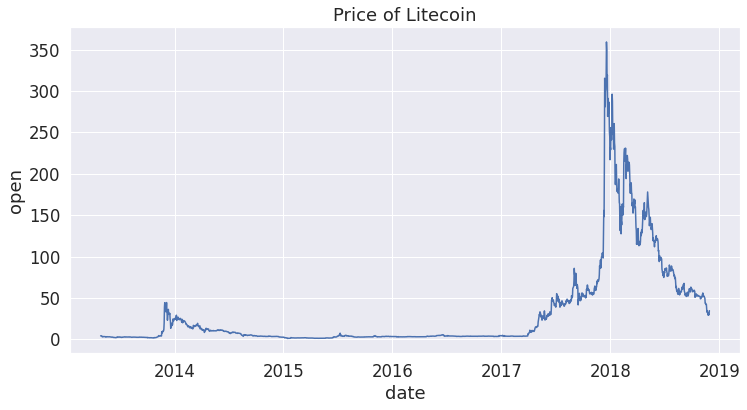

In [6]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="open", data=df).set_title("Price of Litecoin")

Text(0.5, 0.9, 'Down-sampled to 10-day periods')

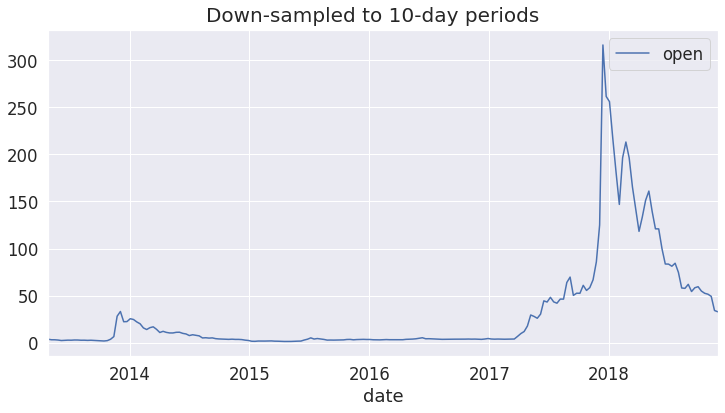

In [7]:
df.resample('10D').mean().plot(figsize=(12,6))
plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

In [8]:
data = df.iloc[:, 0]
hist = []
target = []
length = 90
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [9]:
print(hist[1][89])
print(data[90])
print(target[0])

2.9
2.9
2.9


In [10]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [11]:
hist.shape, target.shape

((1952, 90), (1952, 1))

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [13]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [14]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [22]:
import tensorflow as tf
from tensorflow.keras import layers

In [23]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 90, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 [==============================] - 12s 99ms/step - loss: 0.0053
Epoch 2/30
60/60 [==============================] - 6s 97ms/step - loss: 0.0026
Epoch 3/30
60/60 [==============================] - 6s 98ms/step - loss: 0.0023
Epoch 4/30
60/60 [==============================] - 6s 97ms/step - loss: 0.0019
Epoch 5/30
60/60 [==============================] - 6s 101ms/step - loss: 0.0020
Epoch 6/30
60/60 [==============================] - 6s 96ms/step - loss: 0.0018
Epoch 7/30
60/60 [==============================] - 6s 98ms/step - loss: 0.0020
Epoch 8/30
60/60 [==============================] - 6s 95ms/step - loss: 0.0019
Epoch 9/30
60/60 [==============================] - 6s 97ms/step - loss: 0.0017
Epoch 10/30
60/60 [==============================] - 6s 96ms/step - loss: 0.0020
Epoch 11/30
60/60 [==============================] - 6s 100ms/step - loss: 0.0018
Epoch 12/30
60/60 [==============================] - 6s 94ms/step - loss: 0.0015
Epoch 13/30
60/60 [===============

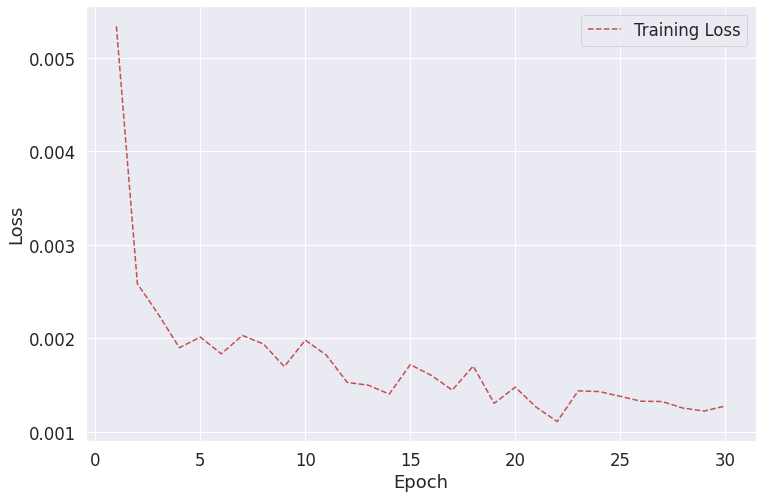

In [27]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

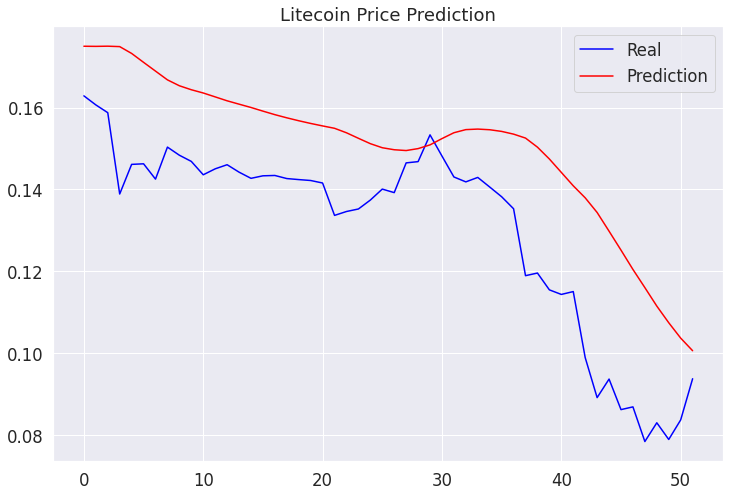

In [28]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Litecoin Price Prediction')
plt.legend()
plt.show()